In [57]:
# Import nilearn and numpy
from nilearn import datasets
from nilearn import surface
import numpy as np
import pandas as pd
import glob
from nilearn import signal
from scipy import stats
%matplotlib inline


In [53]:
# Load VWFA1 fsaverage ROI
vwfa1 = surface.load_surf_data('/scratch/groups/jyeatman/visfAtlas/FreeSurfer/MPM_lh_OTS.label')
# Load fsaverage
fsaverage = datasets.fetch_surf_fsaverage('fsaverage')

In [108]:
# Load 1 run of a participant's resting state data in fsaverage space
subs = ['107', '108', '173', '230', '309', '984', '1210', '1211', '1215','1234', '1335', '1339','1380','1452','1453']
group_map = np.zeros(shape = (163842,len(subs)))

for ii in range(len(subs)):
    datadir = ('/scratch/groups/jyeatman/LMB_BIDS/derivatives/fmriprep/sub-' + subs[ii] + '/ses-2/func/')
    run1gii = (datadir + 'sub-' + subs[ii] + '_ses-2_task-rest_run-1_space-fsaverage_hemi-L_bold.func.gii')
    print(glob.glob(run1gii))
    run2gii = (datadir + 'sub-' + subs[ii] + '_ses-2_task-rest_run-2_space-fsaverage_hemi-L_bold.func.gii')
    print(glob.glob(run2gii))

['/scratch/groups/jyeatman/LMB_BIDS/derivatives/fmriprep/sub-107/ses-2/func/sub-107_ses-2_task-rest_run-1_space-fsaverage_hemi-L_bold.func.gii']
['/scratch/groups/jyeatman/LMB_BIDS/derivatives/fmriprep/sub-107/ses-2/func/sub-107_ses-2_task-rest_run-2_space-fsaverage_hemi-L_bold.func.gii']
['/scratch/groups/jyeatman/LMB_BIDS/derivatives/fmriprep/sub-108/ses-2/func/sub-108_ses-2_task-rest_run-1_space-fsaverage_hemi-L_bold.func.gii']
['/scratch/groups/jyeatman/LMB_BIDS/derivatives/fmriprep/sub-108/ses-2/func/sub-108_ses-2_task-rest_run-2_space-fsaverage_hemi-L_bold.func.gii']
['/scratch/groups/jyeatman/LMB_BIDS/derivatives/fmriprep/sub-173/ses-2/func/sub-173_ses-2_task-rest_run-1_space-fsaverage_hemi-L_bold.func.gii']
['/scratch/groups/jyeatman/LMB_BIDS/derivatives/fmriprep/sub-173/ses-2/func/sub-173_ses-2_task-rest_run-2_space-fsaverage_hemi-L_bold.func.gii']
['/scratch/groups/jyeatman/LMB_BIDS/derivatives/fmriprep/sub-230/ses-2/func/sub-230_ses-2_task-rest_run-1_space-fsaverage_hemi-L_b

In [109]:
# Load 1 run of a participant's resting state data in fsaverage space
subs = ['107', '108', '173', '230', '309', '984', '1210','1234', '1335', '1339','1380','1452','1453']
# Missing runs  '1211' , '1215'
group_map = np.zeros(shape = (163842,len(subs)))

for ii in range(len(subs)):
    datadir = ('/scratch/groups/jyeatman/LMB_BIDS/derivatives/fmriprep/sub-' + subs[ii] + '/ses-2/func/')
    run1gii = (datadir + 'sub-' + subs[ii] + '_ses-2_task-rest_run-1_space-fsaverage_hemi-L_bold.func.gii')
    print('Loading data for participant ' + subs[ii])
    print('Loading run 1:' + run1gii)
    run1 = surface.load_surf_data(run1gii)
    run2gii = (datadir + 'sub-' + subs[ii] + '_ses-2_task-rest_run-2_space-fsaverage_hemi-L_bold.func.gii')
    print('Loading run 1:' + run2gii)
    run2 = surface.load_surf_data(run1gii)
    
    # Loading confounds
    con1 = pd.read_csv(datadir + 'sub-' + subs[ii] + '_ses-2_task-rest_run-1_desc-confounds_timeseries.tsv', sep = '\t')
    con2 = pd.read_csv(datadir + 'sub-' + subs[ii] +  '_ses-2_task-rest_run-2_desc-confounds_timeseries.tsv', sep = '\t')
    con1 = con1[['csf', 'white_matter','trans_x', 'trans_x_derivative1', 'trans_y','trans_y_derivative1','trans_z', 
             'trans_z_derivative1', 'rot_x', 'rot_x_derivative1','rot_y','rot_y_derivative1', 
             'rot_z', 'rot_z_derivative1']]
    con2 = con2[['csf', 'white_matter','trans_x', 'trans_x_derivative1', 'trans_y','trans_y_derivative1','trans_z', 
             'trans_z_derivative1', 'rot_x', 'rot_x_derivative1','rot_y','rot_y_derivative1', 
             'rot_z', 'rot_z_derivative1']]
    
    # drop first 6 timepoints
    droptp = [0,1,2,3,4,5]
    print('Original Data Vertices by Timepoints')
    print(run1.shape)
    run1 = np.delete(run1,droptp,axis=1)
    run2 = np.delete(run2,droptp,axis=1)
    con1 = con1.drop(droptp)
    con2 = con2.drop(droptp)
    print('Vertices by Timepoints after dropping initial 6 timepoints')
    print(run1.shape)
    print(run2.shape)
    print(con1.shape)
    print(con2.shape)
    
    # Signal clean
    run1 = np.transpose(signal.clean(signals = np.transpose(run1), filter=None, detrend=True, standardize='zscore',confounds = con1))
    run2 = np.transpose(signal.clean(signals = np.transpose(run1), filter=None, detrend=True, standardize='zscore',confounds = con2))
    runs = np.concatenate((run1,run2),axis=1)
    print(runs.shape)
    
    # Compute the mean time series for the ROI
    seed_timeseries = np.mean(runs[vwfa1], axis=0)
    
    # Plot mean timeseries
    #import matplotlib.pyplot as plt

    #plt.plot(seed_timeseries)
    #plt.title('Seed time series (Posterior cingulate cortex)')
    #plt.xlabel('Scan number')
    #plt.ylabel('Normalized signal')
    #plt.tight_layout()
    
    # Compute correlations between the seed timeseries and each vertex
    stat_map = np.zeros(run1.shape[0])
    for i in range(run1.shape[0]):
        stat_map[i] = stats.pearsonr(seed_timeseries, runs[i])[0]
    
    # Add the stat map to the group stat map
    group_map[:,ii] = stat_map
    
    # Now plot the seed based connectivity
    plotting.plot_surf_stat_map(fsaverage['white_left'], stat_map=stat_map,
        hemi='left', threshold = .3, vmax=0.7, view='lateral', colorbar=True,
        bg_map=fsaverage['curv_left'], title='Correlation map', output_file = ('/scratch/groups/jyeatman/images/sub-' + subs[ii] + '_ses-2_MPM_lh_OTS_lateral.png' ))
    
    plotting.plot_surf_stat_map(fsaverage['white_left'], stat_map=stat_map,
        hemi='left', threshold = .3, vmax=0.7, view='ventral', colorbar=True,
        bg_map=fsaverage['curv_left'], title='Correlation map', output_file = ('/scratch/groups/jyeatman/images/sub-' + subs[ii] + '_ses-2_MPM_lh_OTS_ventral.png' ))
    
    

Loading data for participant 107
Loading run 1:/scratch/groups/jyeatman/LMB_BIDS/derivatives/fmriprep/sub-107/ses-2/func/sub-107_ses-2_task-rest_run-1_space-fsaverage_hemi-L_bold.func.gii
Loading run 1:/scratch/groups/jyeatman/LMB_BIDS/derivatives/fmriprep/sub-107/ses-2/func/sub-107_ses-2_task-rest_run-2_space-fsaverage_hemi-L_bold.func.gii
Original Data Vertices by Timepoints
(163842, 375)
Vertices by Timepoints after dropping initial 6 timepoints
(163842, 369)
(163842, 369)
(369, 14)
(369, 14)
(163842, 738)


/home/users/jyeatman/.local/lib/python3.6/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading data for participant 108
Loading run 1:/scratch/groups/jyeatman/LMB_BIDS/derivatives/fmriprep/sub-108/ses-2/func/sub-108_ses-2_task-rest_run-1_space-fsaverage_hemi-L_bold.func.gii
Loading run 1:/scratch/groups/jyeatman/LMB_BIDS/derivatives/fmriprep/sub-108/ses-2/func/sub-108_ses-2_task-rest_run-2_space-fsaverage_hemi-L_bold.func.gii
Original Data Vertices by Timepoints
(163842, 375)
Vertices by Timepoints after dropping initial 6 timepoints
(163842, 369)
(163842, 369)
(369, 14)
(369, 14)
(163842, 738)
Loading data for participant 173
Loading run 1:/scratch/groups/jyeatman/LMB_BIDS/derivatives/fmriprep/sub-173/ses-2/func/sub-173_ses-2_task-rest_run-1_space-fsaverage_hemi-L_bold.func.gii
Loading run 1:/scratch/groups/jyeatman/LMB_BIDS/derivatives/fmriprep/sub-173/ses-2/func/sub-173_ses-2_task-rest_run-2_space-fsaverage_hemi-L_bold.func.gii
Original Data Vertices by Timepoints
(163842, 375)
Vertices by Timepoints after dropping initial 6 timepoints
(163842, 369)
(163842, 369)
(369

In [110]:
# Calculate the mean
group_mean = np.mean(group_map, axis = 1)

In [113]:
# Now plot the seed based connectivity
plotting.plot_surf_stat_map(fsaverage['white_left'], stat_map=group_mean,
        hemi='left', threshold = .2, vmax=0.5, view='lateral', colorbar=True,
        bg_map=fsaverage['curv_left'], title='Correlation map', output_file = ('/scratch/groups/jyeatman/images/' + 'Group_Mean_Lateral' + '_ses-2_MPM_lh_OTS.png' ))
    
# Now plot the seed based connectivity
plotting.plot_surf_stat_map(fsaverage['white_left'], stat_map=group_mean,
        hemi='left', threshold = .2, vmax=0.5, view='ventral', colorbar=True,
        bg_map=fsaverage['curv_left'], title='Correlation map', output_file = ('/scratch/groups/jyeatman/images/' + 'Group_Mean_Lateral' + '_ses-2_MPM_lh_OTS.png' ))
    
    

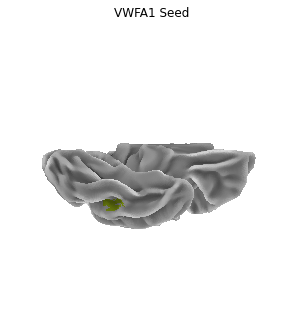

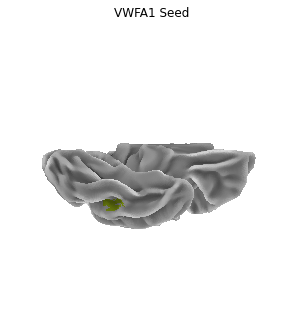

In [28]:
# Transform ROI indices to a "roi_map" which is what nilearn calls a mask
# Plot this ROI on the cortical surface
vwfa1_map = np.zeros(run1.shape[0], dtype=int)
vwfa1_map[vwfa1] = 1
from nilearn import plotting
plotting.plot_surf_roi(fsaverage['white_left'], roi_map=vwfa1_map,
                       hemi='left', view='ventral',
                       bg_map=fsaverage['curv_left'], bg_on_data=True,
                       title='VWFA1 Seed')

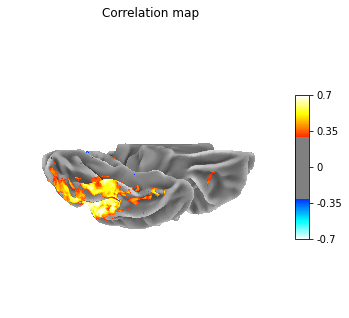

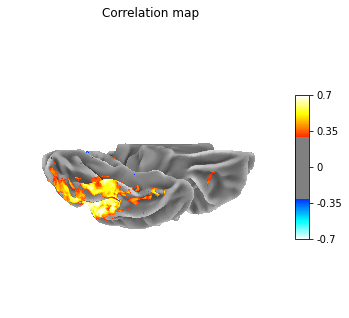

In [72]:
# Plot on ventral surface
plotting.plot_surf_stat_map(fsaverage['white_left'], stat_map=stat_map,
                            hemi='left', threshold = .3,vmax = 0.7, view='ventral', colorbar=True,
                            bg_map=fsaverage['curv_left'], title='Correlation map')